# Support Vector Machine

- 先来个简单版本的SMO

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [111]:
def select_random(index, m):
    j = index
    while j == index:
        j = int(np.random.uniform(0, m))
    return j

In [112]:
def clipAlpha(alpha, High, Low):
    if alpha > High:
        alpha = High
    elif Low > alpha:
        alpha = Low
    return alpha

In [113]:
select_random(2, 10)

4

In [114]:
df = pd.read_csv('testSet.txt', delimiter='\t', names=['x1', 'x2', 'y'])

In [115]:
df.head()

,x1,x2,y
0,3.542485,1.977398,-1
1,3.018896,2.556416,-1
2,7.551510,-1.580030,1
3,2.114999,-0.004466,-1
4,8.127113,1.274372,1


In [116]:
def simpleSMO(df, C, toler, maxIter):
    data = df.loc[:, ['x1', 'x2']]
    labels = df.loc[:, 'y'].values
    b = 0
    m,n = df.shape
    alphas = np.zeros((m, ))
    iteration = 0
    while iteration < maxIter:
        alphaPairsChanged = 0
        for i in range(m):
            gXi = np.dot(alphas*labels, np.dot(data, data.loc[i].T))+ b# prediction of class
            Ei = gXi - float(labels[i]) # the error between predcition and  real class
            if ((labels[i]*Ei < -toler) and (alphas[i] < C)) or \
            ((labels[i]*Ei > toler) and (alphas[i] > 0)): # test the error abs(Ei) # about KKT condition???????
                j = select_random(i, m) # select an alpha_j randomly
                gXj = np.dot(alphas*labels, np.dot(data, data.loc[j].T)) + b
                Ej = gXj - float(df.loc[j, 'y'])
                alphaIold = alphas[i].copy() # save the old alpha_i
                alphaJold = alphas[j].copy()
                if labels[i] != labels[j]:
                    Low = max(0, alphas[j] - alphas[i])
                    High = min(C, C + alphas[j] - alphas[i])
                else:
                    Low = max(0, alphas[j] + alphas[i] - C)
                    High = min(C, alphas[j] + alphas[i])
                if Low == High:
                    # print "L==H"
                    continue
                eta = 2.0 * data.loc[i].dot(data.loc[j].T) - data.loc[i].dot(data.loc[i].T) - \
                      data.loc[j].dot(data.loc[j].T)    # the opmitmal amount to change alpha_j
                if eta >= 0:
                    # print "eta>=0"
                    continue
                alphas[j] -= labels[j]*(Ei - Ej)/eta
                alphas[j] = clipAlpha(alphas[j], High, Low)
                if (abs(alphas[j] - alphaJold) < 0.00001) :
                    # print "j not moving enough"
                    continue
                alphas[i] += labels[j]*labels[i]*(alphaJold - alphas[j]) # alpha_i is changed by the same amount
                                                                         # but oppsite direction
                
                b1 = b - Ei - labels[i]*(alphas[i] - alphaIold)*\
                     data.loc[i].dot(data.loc[i].T) - labels[j]*(alphas[j] - alphaJold)*\
                     data.loc[i].dot(data.loc[j].T)
                b2 = b - Ej - labels[i]*(alphas[i] - alphaIold)*\
                     data.loc[i].dot(data.loc[j].T) - labels[j]*(alphas[j] - alphaJold)*\
                     data.loc[j].dot(data.loc[j].T)
                
                if (0 < alphas[i]) and (C > alphas[i]):
                    b  = b1
                elif (0 < alphas[j]) and (C > alphas[j]):
                    b = b2
                else:
                    b = (b1 + b2)/2.0
                alphaPairsChanged += 1
                # print "iteration: %d, i: %d, pairs changed %d" % (iteration, i, alphaPairsChanged)
        if (alphaPairsChanged == 0):
            iteration += 1
        else:
            iteration = 0
        # print "Iteration number: %d" % iteration
    return b, alphas

In [117]:
b, alphas = simpleSMO(df, 0.6, 0.001, 40)

In [118]:
b

-3.7914744655976307

In [119]:
alphas[alphas>0]

array([ 0.1343102 ,  0.21792382,  0.01405526,  0.36628927])

## Get the support vectors

In [120]:
for i in range(100):
    if alphas[i] > 0.:
        print df.loc[i, :]

x1    4.658191
x2    3.507396
y    -1.000000
Name: 17, dtype: float64
x1    3.457096
x2   -0.082216
y    -1.000000
Name: 29, dtype: float64
x1    2.893743
x2   -1.643468
y    -1.000000
Name: 52, dtype: float64
x1    6.080573
x2    0.418886
y     1.000000
Name: 55, dtype: float64


## Get the separating hyperplane

In [121]:
labels = df.loc[:, 'y'].values
data = df.loc[:, ['x1', 'x2']].values

In [122]:
w = np.dot(alphas*lables, data)

In [123]:
w

array([ 0.80755025, -0.2766294 ])

## Plot

In [124]:
x = np.linspace(-1, 10, 1000)

In [125]:
def f(x, w):
    return -w[0]*x/w[1]-b/w[1]

(-2, 11)

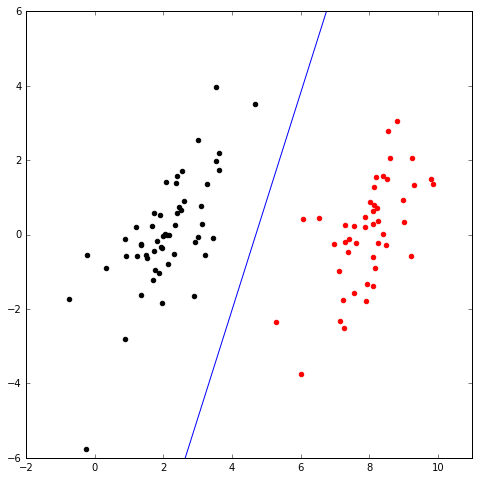

In [128]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(df[df['y']==1].loc[: ,'x1'], df[df['y']==1].loc[: ,'x2'], color='r')
ax.scatter(df[df['y']==-1].loc[: ,'x1'], df[df['y']==-1].loc[: ,'x2'], color='k')
ax.plot(x, f(x, w))

ax.set_ylim([-6, 6])
ax.set_xlim([-2, 11])

# The Full Platt SMO

## Some support functions 

In [129]:
class optStruct:
    def __init__(self, data, labels, C, toler):
        self.X = data
        self.labels = labels
        self.C = C
        self.tol = toler
        self.m = data.shape[0]
        self.alphas = np.zeros((self.m, ))
        self.b = 0
        self.errCache = np.zeros((self.m, 2)) # store error cache

Tip: learn to use CLASS to create the data structure

In [130]:
def calculateEk(oS, k):
    fXk = np.dot(oS.alphas*oS.labels, np.dot(oS.X, oS.X[k].T))+ oS.b
    Ek = fXk - float(oS.labels[k])
    return Ek

In [131]:
def selectJ(i, oS, Ei):
    maxK = -1
    maxDeltaE = 0
    Ej = 0
    oS.errCache[i] = [1, Ei]
    validEcacheList = np.nonzero(oS.errCache[:, 0])[0]
    if (len(validEcacheList)) > 1:
        for k in validEcacheList:
            if k == i:
                continue
            Ek = calculateEk(oS, k)
            deltaE = abs(Ei - Ek)
            if (deltaE > maxDeltaE):
                maxK = k
                maxDeltaE = deltaE
                Ej = Ek
        return maxK, Ej
    else:
        # This is for the first time to choose an alpha
        j = select_random(i, oS.m)
        Ej = calculateEk(oS, j)
    return j, Ej

In [132]:
def updateEk(oS, k):
    Ek = calculateEk(oS, k)
    oS.errCache[k] = [1, Ek]

In [133]:
def innerLoop(i, oS):
    Ei = calculateEk(oS, i)
    if ((oS.labels[i]*Ei < -oS.tol) and (oS.alphas[i] < oS.C)) or\
       ((oS.labels[i]*Ei > -oS.tol) and (oS.alphas[i] > 0)):
        j, Ej = selectJ(i, oS, Ei) # different from simpleSMO
        alphaIold = oS.alphas[i].copy()
        alphaJold = oS.alphas[j].copy()
        if (oS.labels[i] != oS.labels[j]):
            Low = max(0, oS.alphas[j] - oS.alphas[i])
            High = min(oS.C, oS.C + oS.alphas[j] - oS.alphas[i])
        else:
            Low = max(0, oS.alphas[j] + oS.alphas[i] - oS.C)
            High = min(oS.C, oS.alphas[j] + oS.alphas[i])
        if Low == High:
            print "L==H"
            return 0
        eta = 2.0 * oS.X[i].dot(oS.X[j].T) - oS.X[i].dot(oS.X[i].T) - oS.X[j].dot(oS.X[j].T)
        if eta >= 0:
            print"eta>=0"
            return 0
        oS.alphas[j] -= oS.labels[j]*(Ei - Ej)/eta
        oS.alphas[j] = clipAlpha(oS.alphas[j], High, Low)
        updateEk(oS, j)
        if (abs(oS.alphas[j] - alphaJold) < 0.00001):
            print "j not moving enough"
            return 0
        oS.alphas[i] += oS.labels[j]*oS.labels[i]*(alphaJold - oS.alphas[j])
        updateEk(oS, i)
        b1 = oS.b - Ei - oS.labels[i]*(oS.alphas[i] - alphaIold)*oS.X[i].dot(oS.X[i].T) -\
             oS.labels[j]*(oS.alphas[j] - alphaJold)*oS.X[i].dot(oS.X[j].T)
        b2 = oS.b - Ej - oS.labels[i]*(oS.alphas[i] - alphaIold)*oS.X[i].dot(oS.X[j].T) -\
             oS.labels[j]*(oS.alphas[j] - alphaJold)*oS.X[j].dot(oS.X[j].T)
        if (0 < oS.alphas[i]) and (oS.C > oS.alphas[j]):
            oS.b = b1
        elif (0 < oS.alphas[j]) and (oS.C > oS.alphas[j]):
            oS.b = b2
        else:
            oS.b = (b1 + b2)/2.0
        return 1
    else:
        return 0
        

In [134]:
def SMO(data, labels, C, toler, maxIter, kTup=('lin', 0)):
    oS = optStruct(data, labels, C, toler)
    iteration = 0
    entireSet = True
    alphaPairsChanged = 0
    while (iteration < maxIter) and ((alphaPairsChanged > 0) or (entireSet)):
        alphaPairsChanged = 0
        if entireSet:
            for i in range(oS.m):
                alphaPairsChanged += innerLoop(i, oS)
            print "fullset, iter: %d, i: %d, pairs changed: %d" %(iteration, i , alphaPairsChanged)
            iteration += 1
        else:
            nonBoundIs = np.nonzero((oS.alphas > 0) * (oS.alphas < C))[0]
            for i in nonBoundIs:
                alphaPairsChanged += innerLoop(i ,oS)
                print "non-bound, iter: %d, i: %d, pairs changed: %d" %(iteration, i , alphaPairsChanged)
            iteration += 1
        if entireSet:
            entireSet = False
        elif (alphaPairsChanged == 0):
            entireSet = True
        print "Iteraion number: %d" %iteration
    return oS.b, oS.alphas

In [145]:
b, alphas = SMO(data, labels, 1, 0.001, 40)

L==H
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
L==H
j not moving enough
L==H
L==H
j not moving enough
L==H
L==H
L==H
L==H
L==H
j not moving enough
fullset, iter: 0, i: 99, pairs changed: 6
Iteraion number: 1
j not moving enough
non-bound, iter: 1, i: 0, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 3, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 4, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 17, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 18, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 25, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 46, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 55, pairs changed: 0
j not moving enough
non-bound, iter: 1, i: 94, pairs changed: 0
Iteraion number: 2
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
j not moving enough
L==H
j not moving enough
j not moving enough
L=

In [146]:
b

-2.8990174816005938

In [147]:
alphas[alphas>0]

array([ 0.06961952,  0.0169055 ,  0.0169055 ,  0.0272699 ,  0.04522972,
        0.0272699 ,  0.0243898 ,  0.06140181,  0.06140181])

In [148]:
for i in range(100):
    if alphas[i] > 0.:
        print df.loc[i, :]

x1    3.542485
x2    1.977398
y    -1.000000
Name: 0, dtype: float64
x1    2.114999
x2   -0.004466
y    -1.000000
Name: 3, dtype: float64
x1    8.127113
x2    1.274372
y     1.000000
Name: 4, dtype: float64
x1    4.658191
x2    3.507396
y    -1.000000
Name: 17, dtype: float64
x1    8.197181
x2    1.545132
y     1.000000
Name: 18, dtype: float64
x1    7.407860
x2   -0.121961
y     1.000000
Name: 25, dtype: float64
x1    6.960661
x2   -0.245353
y     1.000000
Name: 46, dtype: float64
x1    6.080573
x2    0.418886
y     1.000000
Name: 55, dtype: float64
x1    3.107511
x2    0.758367
y    -1.000000
Name: 94, dtype: float64


In [149]:
w1 = np.dot(alphas*lables, data)

In [150]:
w1

array([ 0.65307162, -0.17196128])

(-2, 11)

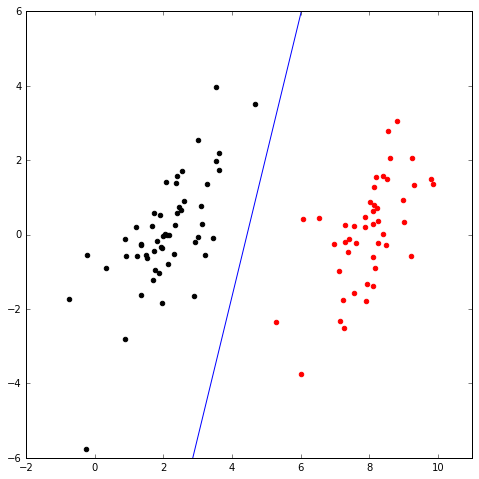

In [151]:
fig, ax = plt.subplots(figsize=(8,8))

ax.scatter(df[df['y']==1].loc[: ,'x1'], df[df['y']==1].loc[: ,'x2'], color='r')
ax.scatter(df[df['y']==-1].loc[: ,'x1'], df[df['y']==-1].loc[: ,'x2'], color='k')
#ax.plot(x, f(x, w))
ax.plot(x, f(x, w1))


ax.set_ylim([-6, 6])
ax.set_xlim([-2, 11])

### Short Summary
- 使用full version 的 SMO 计算速度明显大大加快
- 原因是在inner loop选择第二个alpha的时候有了比较, 选出有最大误差的那一个, 而不是像之前simple version 的随机选取.

**Tip**: np.matrix 有个'A'方法, 就是将np.matrix 转化成 np.array.